# Mountain Car
### Pierpaolo Spaziani - 0316331

In [2]:
import gym
import numpy as np
import imageio
import random
import math
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# In the gym library there is a deprecation about NumPy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gym.utils.passive_env_checker")

# Ignore tensorflow warnings
import logging
tf.get_logger().setLevel(logging.ERROR)

env = gym.make("MountainCar-v0")

2024-01-28 17:14:37.388829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Discretization
In the presence of *continuous states* it is convenient to **discretize** for several reasons:
- Limit the state space
- Memory management
- Faster training
- Generalization

In [24]:
def get_discrete_state(state):
    chunk_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_SIZE
    discrete_state = (state - env.observation_space.low) / chunk_size
    return tuple(discrete_state.astype(int))

### Decay functions

Implementation of decay functions used for ***Learning Rate*** and ***Epsilon***:
- *linear decay*
- *exponential decay*

In [25]:
def decay(episode, type, actual_value, max_value):
    if type == 'linear':
        actual_value = linear_decay(actual_value, max_value)
    elif type == 'exponential':
        actual_value = exponential_decay(episode, max_value)
    return actual_value

def linear_decay(actual_value, max_value):
    decay_rate = max_value / (EPISODES)
    new_value = actual_value - decay_rate
    return max(0, new_value)

def exponential_decay(episode, max_value):
    alpha = -math.log(0.01) / (EPISODES)
    new_value = max_value * math.exp(-alpha * episode)
    return max(0, new_value)

### ε-Greedy

Implementation of the **ε-Greedy** policy for *exploration-exploitation trade-off*:

In [26]:
def epsilon_greedy(epsilon):
    if random.uniform(0, 1) < epsilon:
        # takes a random action
        return random.choice(range(env.action_space.n))
    else:
        # takes the "best" action
        return -1

### Output class

Declaration of a standard output class:

In [27]:
class Output:
    def __init__(self, victory_history, learning_rate_history, epsilon_history, q_table, states_history, states_history_table, reward_history):
        self.victory_history = victory_history
        self.learning_rate_history = learning_rate_history
        self.epsilon_history = epsilon_history
        self.q_table = q_table
        self.states_history = states_history
        self.states_history_table = states_history_table
        self.reward_history = reward_history

### Q-Learning

Implementation of the solution based on **Q-Learning**:

In [28]:
def q_learning():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))
    
    # initialization of parameters
    learning_rate = STARTING_LEARNING_RATE
    epsilon = STARTING_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []

    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        # add the list that will contain the history of states visited during the current episode
        states_history.append([])
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, STARTING_LEARNING_RATE)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, STARTING_EPSILON)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)
        
        done = False
        while not done:
        
            # select an action following the epsilon-greedy policy
            action = epsilon_greedy(epsilon)
            if action < 0:
                action = np.argmax(q_table[discrete_state])

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # add the new state to the history
            states_history[episode].append(new_discrete_state)

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the Q-learning algorithm
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward + DISCOUNT * max_future_q - current_q)
                q_table[discrete_state + (action, )] = new_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward - current_q)
                q_table[discrete_state + (action, )] = new_q
            
            # move to the new state
            discrete_state = new_discrete_state

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)
            
        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history, states_history_table, reward_history)

### SARSA

Implementation of the solution based on **SARSA**:

In [29]:
def SARSA():
    # initialization of the Q-table
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))

    # initialization of parameters
    learning_rate = STARTING_LEARNING_RATE
    epsilon = STARTING_EPSILON
    victories = 0
    victory_history = []
    learning_rate_history = []
    epsilon_history = []
    states_history = []
    states_history_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE))
    reward_history = []
    
    # loop through episodes
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")

        # add the list that will contain the history of states visited during the current episode
        states_history.append([])
        
        # initialize the sum of reward gained during the current episode
        reward_sum = 0

        # reset the environment
        env.reset()

        # get the discrete representation of the current state
        discrete_state = get_discrete_state(env.state)

        states_history_table[discrete_state] = states_history_table[discrete_state] + 1

        # decay the learning rate and epsilon
        learning_rate = decay(episode, LEARNING_RATE_DECAY, learning_rate, STARTING_LEARNING_RATE)
        epsilon = decay(episode, EPSILON_DECAY, epsilon, STARTING_EPSILON)
        learning_rate_history.append(learning_rate)
        epsilon_history.append(epsilon)
        
        # select an action following the epsilon-greedy policy
        action = epsilon_greedy(epsilon)
        if action < 0:
            action = np.argmax(q_table[discrete_state])
        
        done = False
        while not done:

            # execute the action
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # add the new state to the history
            states_history[episode].append(new_discrete_state)

            # update the reward sum
            reward_sum = reward_sum + reward

            states_history_table[new_discrete_state] = states_history_table[new_discrete_state] + 1

            # select a new action following the epsilon-greedy policy
            new_action = epsilon_greedy(epsilon)
            if new_action < 0:
                new_action = np.argmax(q_table[new_discrete_state])
        
            done = terminated or truncated
            if not done:
                # update the current Q-value using the SARSA algorithm
                new_q = q_table[new_discrete_state + (new_action, )]
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward + DISCOUNT * new_q - current_q)
                q_table[discrete_state + (action, )] = updated_q
            elif terminated:
                # if the episode ended successfully
                victories = victories + 1
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward - current_q)
                q_table[discrete_state + (action, )] = updated_q
            
            # move to the new state
            discrete_state = new_discrete_state

            # set the action for next step
            action = new_action

        # add the sum of reward gained to the reward history list
        reward_history.append(reward_sum)

        # update the victory history list
        victory_history.append(victories)
    
    env.close()
    return Output(victory_history, learning_rate_history, epsilon_history, q_table, states_history, states_history_table, reward_history)

# Simulation

### Tuning *EPISODES* & *DISCRETE_SIZE*
In this section we will evaluate the trade-off for the values of **EPISODES** and **DISCRETE_SIZE** with ***no decay*** for *LEARNING_RATE* and *EPSILON*:

In [ ]:
STARTING_LEARNING_RATE = 0.1
DISCOUNT = 0.95
STARTING_EPSILON = 0.2

LEARNING_RATE_DECAY = 'no_decay'
EPSILON_DECAY = 'no_decay'

episodes_list = [1000, 5000, 10000, 50000, 100000]
discrete_size_list = [10, 20, 50, 100, 200]

In [ ]:
q_learning_output = []
sarsa_output = []

for EPISODES in episodes_list:
    for DISCRETE_SIZE in discrete_size_list:
        q_learning_output.append(q_learning())
        sarsa_output.append(SARSA())

### Parameters Setting

For a better comparison between models, the following parameters are common among algorithm simulations:

In [19]:
STARTING_LEARNING_RATE = 1
DISCOUNT = 0.95
STARTING_EPSILON = 1

# DECAY POSSIBLE VALUES:
# no_decay - linear - exponential
LEARNING_RATE_DECAY = 'exponential'
EPSILON_DECAY = 'exponential'

EPISODES = 1000

DISCRETE_SIZE = 20

RUNS = 10

### Q-Learning simulation

In [63]:
q_learning_output = q_learning()
print("There were", q_learning_output.victory_history[-1], "successes!")

There were 620 successes!


### SARSA simulation

In [64]:
sarsa_output = SARSA()
print("There were", sarsa_output.victory_history[-1], "successes!")

There were 873 successes! 554 1151


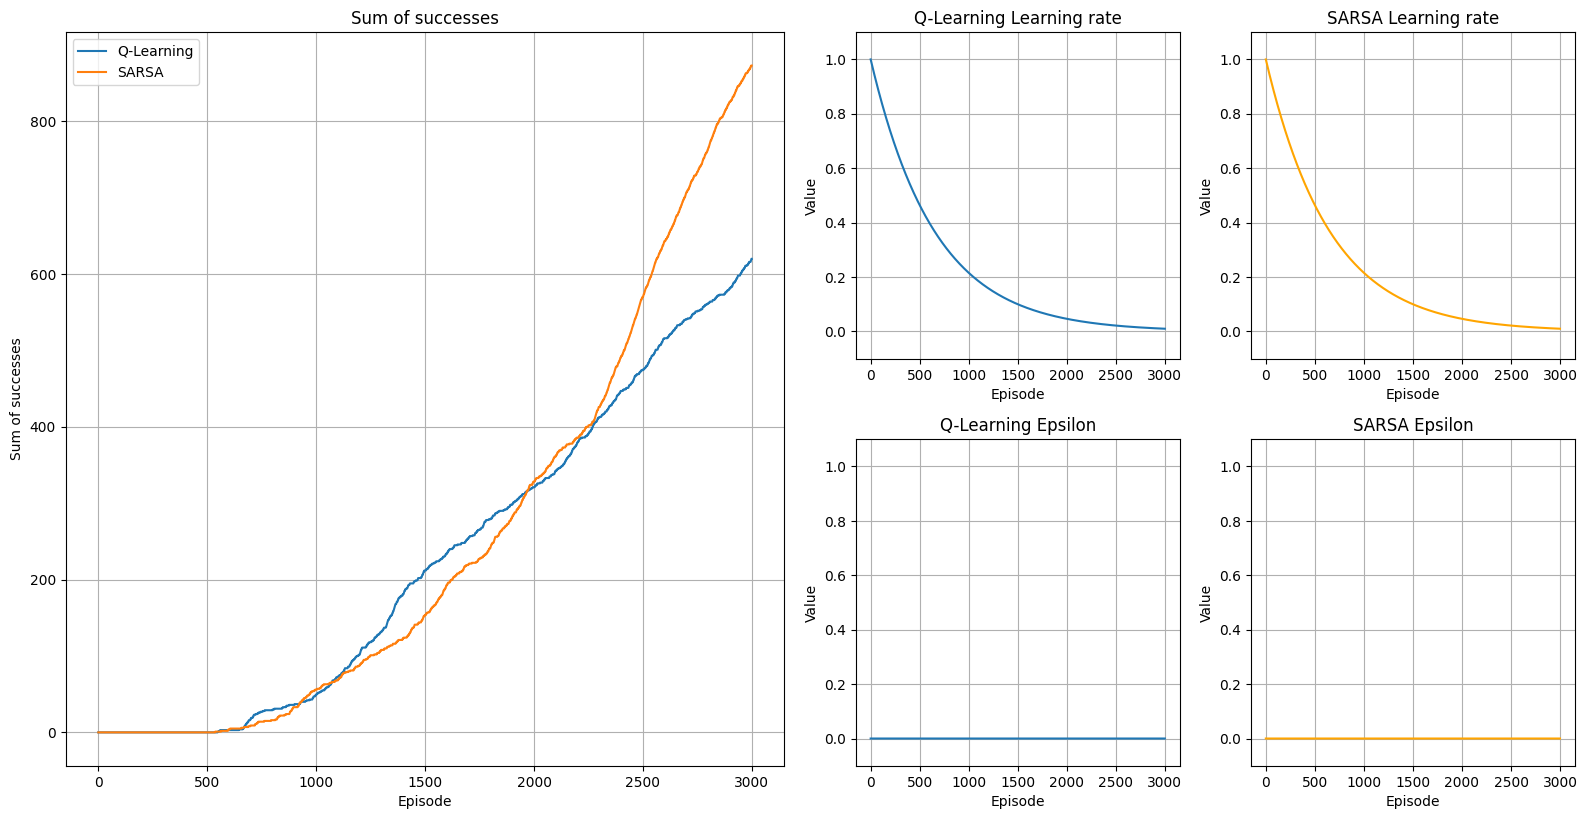

In [65]:
plt.figure(figsize=(16, 16))

plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
plt.plot(q_learning_output.victory_history, label='Q-Learning')
plt.plot(sarsa_output.victory_history, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Sum of successes')
plt.title('Sum of successes')
plt.legend()
plt.grid(True)

plt.subplot2grid((4, 4), (0, 2), rowspan=1, colspan=1)
plt.plot(q_learning_output.learning_rate_history)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Q-Learning Learning rate')
plt.grid(True)

plt.subplot2grid((4, 4), (0, 3), rowspan=1, colspan=1)
plt.plot(sarsa_output.learning_rate_history, color='orange')
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('SARSA Learning rate')
plt.grid(True)

plt.subplot2grid((4, 4), (1, 2), rowspan=1, colspan=1)
plt.plot(q_learning_output.epsilon_history)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Q-Learning Epsilon')
plt.grid(True)

plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1)
plt.plot(sarsa_output.epsilon_history, color='orange')
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('SARSA Epsilon')
plt.grid(True)

plt.tight_layout()

plt.show()

### Analisi Q-Value & Policy

Come risulta evidende dai grafici della Q-Value, gli stati più esterni non vengono toccati. Al contrario, in un'ipotetica implementazione di Value Iteration, ci saremmo aspettati di non avere "buchi" di conoscenza. Questo evidenzia come gli algoritmi ***model-free*** evitano l'apprendiamneto di cose "inutili" (in questo caso stati che non avremmo mai visitato) e tendano a convergere più velocemente.

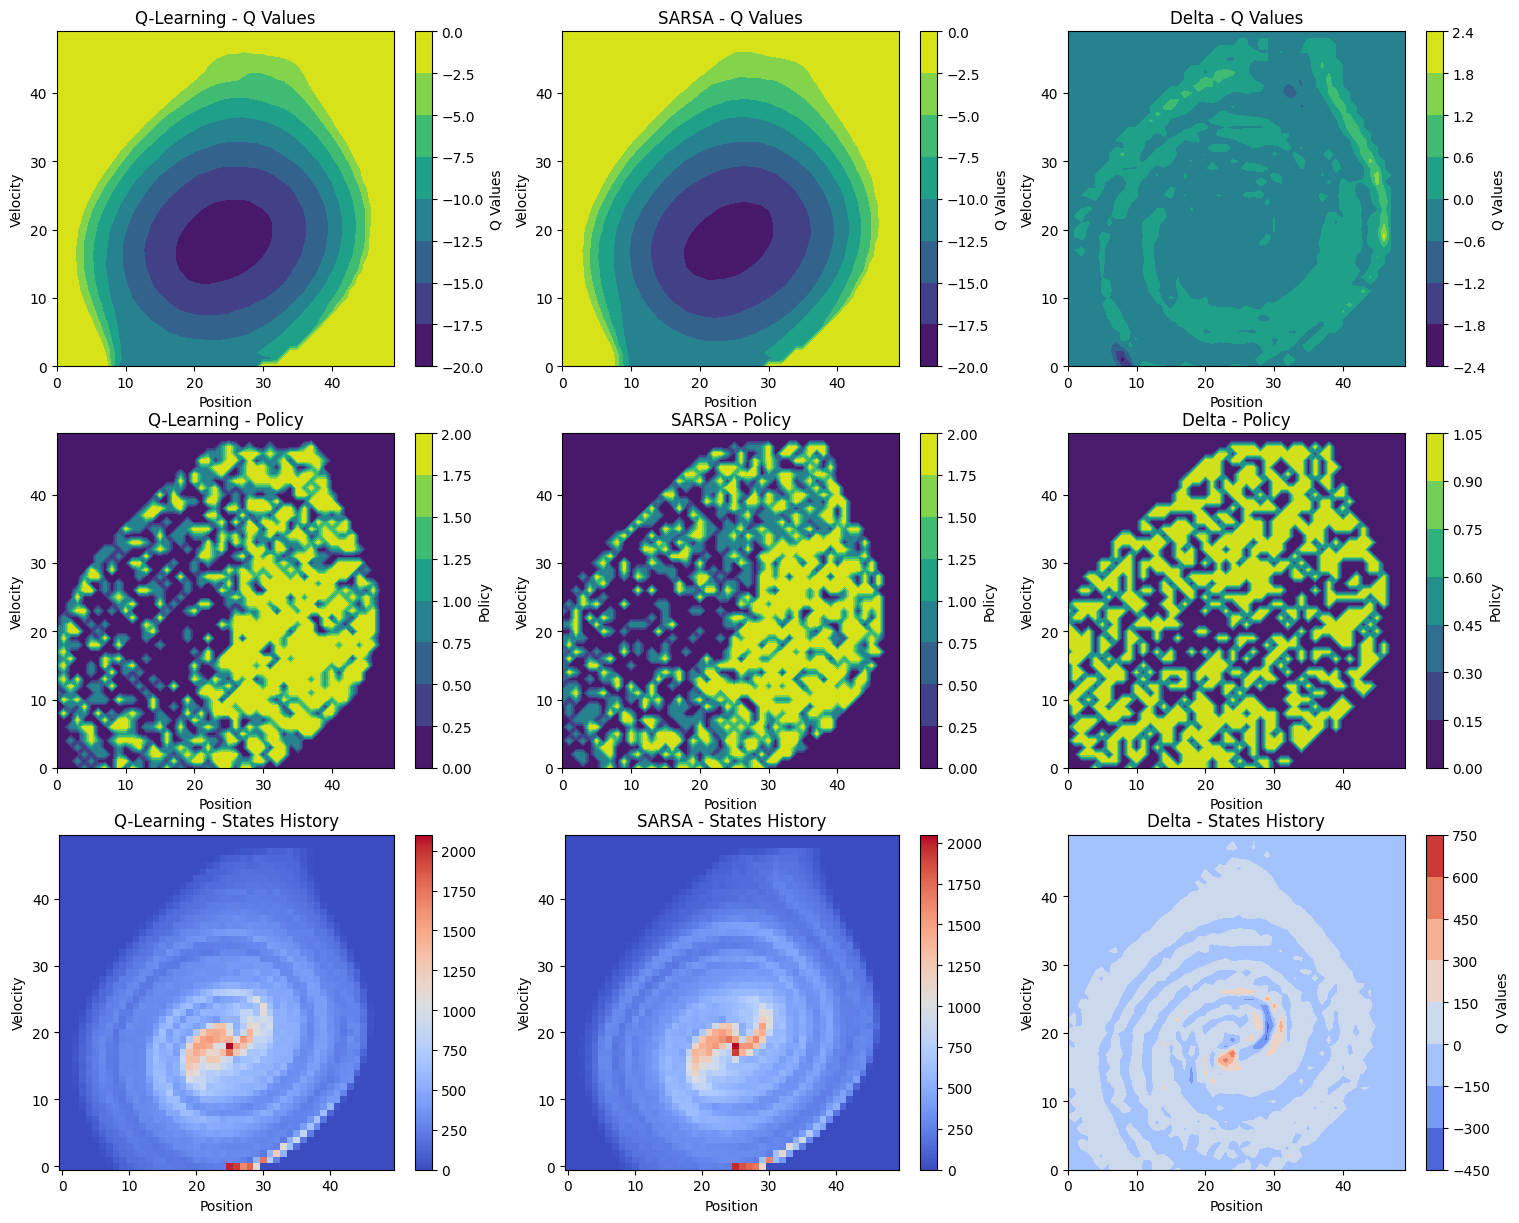

In [66]:
plt.figure(figsize=(25, 20))

# Q-Learning - Q Values
plt.subplot2grid((4, 4), (0, 0), rowspan=1, colspan=1)
q_learning_q_values_plot = plt.contourf(q_learning_output.q_table[:, :, 2])
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Q Values')
plt.colorbar(q_learning_q_values_plot, ax=plt.gca(), label='Q Values')

# Q-Learning - Policy
plt.subplot2grid((4, 4), (1, 0), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.argmax(q_learning_output.q_table, axis=2))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# SARSA - Q Values
plt.subplot2grid((4, 4), (0, 1), rowspan=1, colspan=1)
sarsa_q_values_plot = plt.contourf(sarsa_output.q_table[:, :, 2])
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Q Values')
plt.colorbar(sarsa_q_values_plot, ax=plt.gca(), label='Q Values')

# SARSA - Policy
plt.subplot2grid((4, 4), (1, 1), rowspan=1, colspan=1)
sarsa_policy_plot = plt.contourf(np.argmax(sarsa_output.q_table, axis=2))
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - Policy')
plt.colorbar(sarsa_policy_plot, ax=plt.gca(), label='Policy')

# Delta - Q Values
difference_q_values = q_learning_output.q_table[:, :, 2] - sarsa_output.q_table[:, :, 2]
plt.subplot2grid((4, 4), (0, 2), rowspan=1, colspan=1)
difference_plot = plt.contourf(difference_q_values, cmap='viridis')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Delta - Q Values')
plt.colorbar(difference_plot, ax=plt.gca(), label='Q Values')

# Delta - Policy
q_learning_policy = np.argmax(q_learning_output.q_table, axis=2)
sarsa_policy = np.argmax(sarsa_output.q_table, axis=2)
policy_difference = (q_learning_policy != sarsa_policy).astype(int)
plt.subplot2grid((4, 4), (1, 2), rowspan=1, colspan=1)
difference_plot = plt.contourf(policy_difference, cmap='viridis')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Delta - Policy')
plt.colorbar(difference_plot, ax=plt.gca(), label='Policy')

# Q-Learning - States History
plt.subplot2grid((4, 4), (2, 0), rowspan=1, colspan=1)
plt.imshow(q_learning_output.states_history_table, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Q-Learning - States History')
plt.gca().invert_yaxis()

# SARSA - States History
plt.subplot2grid((4, 4), (2, 1), rowspan=1, colspan=1)
plt.imshow(sarsa_output.states_history_table, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('SARSA - States History')
plt.gca().invert_yaxis()

# Delta - States History
difference_q_values = q_learning_output.states_history_table - sarsa_output.states_history_table
plt.subplot2grid((4, 4), (2, 2), rowspan=1, colspan=1)
difference_plot = plt.contourf(difference_q_values, cmap='coolwarm')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Delta - States History')
plt.colorbar(difference_plot, ax=plt.gca(), label='Q Values')

plt.show()

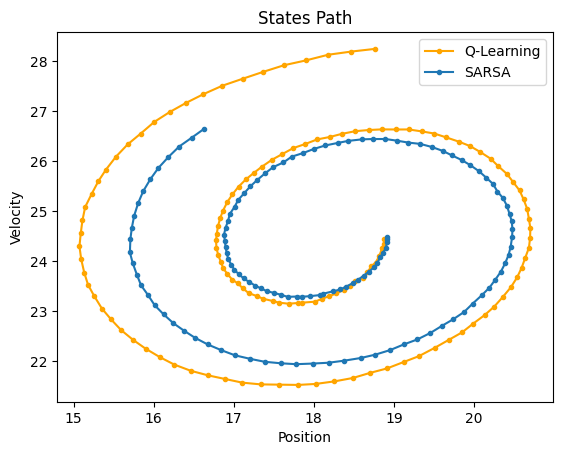

In [67]:
transposed_output = list(map(list, zip(*q_learning_output.states_history)))
average_values = [(np.mean([x[0] for x in column]), np.mean([y[1] for y in column])) for column in transposed_output]
x_values, y_values = zip(*average_values)
plt.plot(x_values, y_values, marker='.', linestyle='-', color='orange', label='Q-Learning')

transposed_output = list(map(list, zip(*sarsa_output.states_history)))
average_values = [(np.mean([x[0] for x in column]), np.mean([y[1] for y in column])) for column in transposed_output]
x_values, y_values = zip(*average_values)
plt.plot(x_values, y_values, marker='.', linestyle='-', label='SARSA')

#plt.axvline(x=(env.env.goal_position - (env.observation_space.low)[0]) / chunk_size[0], color='red', linestyle='--', label='Goal')

plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('States Path')
plt.legend()

plt.show()

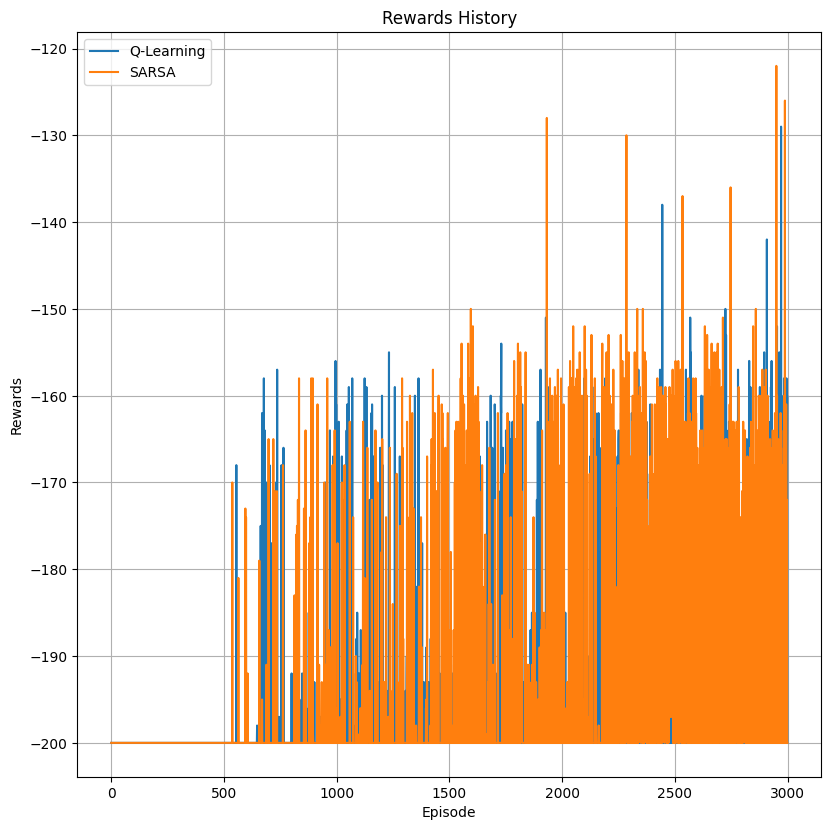

In [68]:
plt.figure(figsize=(16, 16))

plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
plt.plot(q_learning_output.reward_history, label='Q-Learning')
plt.plot(sarsa_output.reward_history, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards History')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

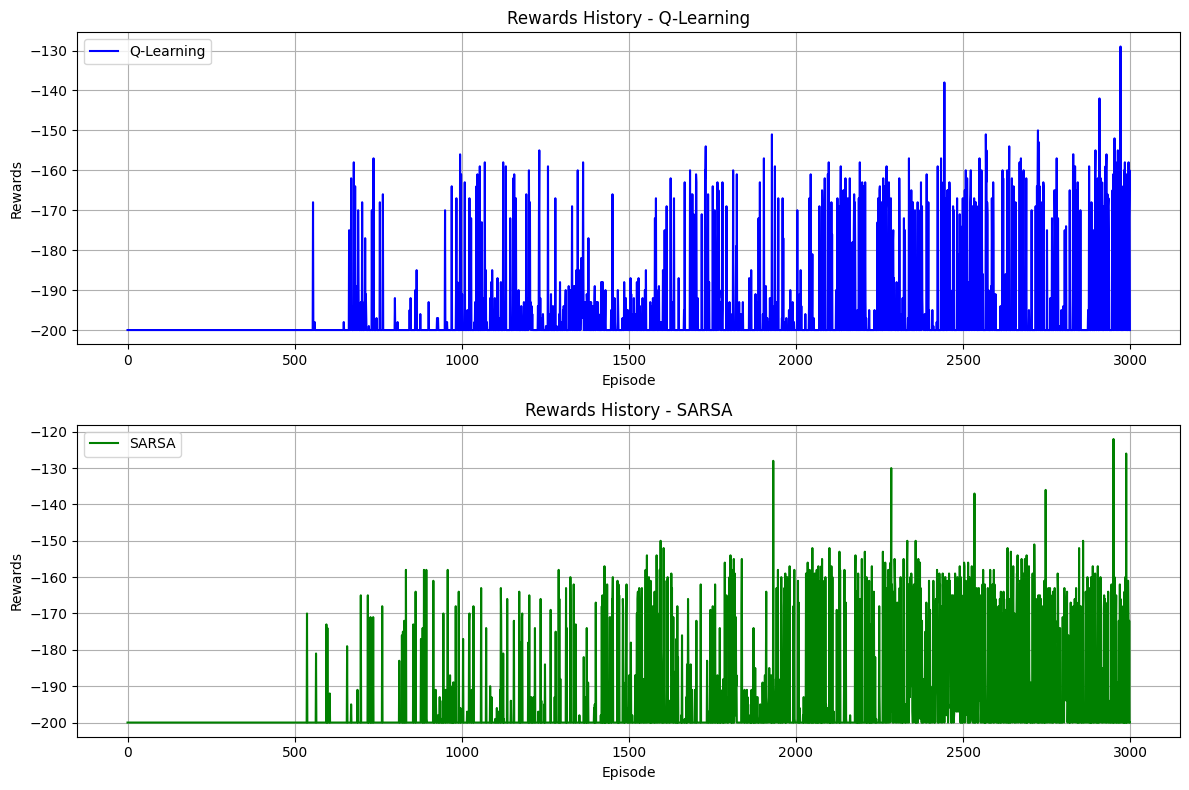

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Sottografo per Q-Learning
ax[0].plot(q_learning_output.reward_history, label='Q-Learning', color='blue')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Rewards')
ax[0].set_title('Rewards History - Q-Learning')
ax[0].legend()
ax[0].grid(True)

# Sottografo per SARSA
ax[1].plot(sarsa_output.reward_history, label='SARSA', color='green')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Rewards')
ax[1].set_title('Rewards History - SARSA')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
q_learning_output = []
sarsa_output = []
for run in range (RUNS):
    print("Q-Learning:", run)
    q_learning_output.append(q_learning())
    print("SARSA:", run)
    sarsa_output.append(SARSA())

In [86]:
q_learning_reward_history = q_learning_output[0].reward_history
for i in range(1,RUNS):
    q_learning_reward_history = [x + y for x, y in zip(q_learning_reward_history, q_learning_output[i].reward_history)]
q_learning_reward_history = [x / RUNS for x in q_learning_reward_history]

sarsa_reward_history = sarsa_output[0].reward_history
for i in range(1,RUNS):
    sarsa_reward_history = [x + y for x, y in zip(sarsa_reward_history, sarsa_output[i].reward_history)]
sarsa_reward_history = [x / RUNS for x in sarsa_reward_history]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Sottografo per Q-Learning
ax[0].plot(q_learning_reward_history, label='Q-Learning', color='blue')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Rewards')
ax[0].set_title('Rewards History - Q-Learning')
ax[0].legend()
ax[0].grid(True)

# Sottografo per SARSA
ax[1].plot(sarsa_reward_history, label='SARSA', color='green')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Rewards')
ax[1].set_title('Rewards History - SARSA')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Creazione del modello
state_dim = env.observation_space.shape[0] # 2
num_actions = env.action_space.n           # 3

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(state_dim,)),
    tf.keras.layers.Dense(num_actions, activation='softmax')
])

# Definizione della funzione di perdita e dell'ottimizzatore
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Funzione per ottenere l'azione secondo la distribuzione di probabilità prevista dal modello
def get_action(state):
    state = np.reshape(state, [1, state_dim])              # crea una matrice bidimensionale
    action_prob = model.predict(state, verbose=0)[0]
    action = np.random.choice(num_actions, p=action_prob)
    return action

# Funzione per calcolare i ritorni scontati
def compute_discounted_returns(rewards, gamma=0.99):
    discounted_returns = np.zeros_like(rewards, dtype=np.float32)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        discounted_returns[t] = running_add
    return discounted_returns

# Funzione di training con REINFORCE
def train_step(states, actions, discounted_returns):
    with tf.GradientTape() as tape:
        action_probs = model(states, training=True)
        chosen_probs = tf.reduce_sum(tf.one_hot(actions, num_actions) * action_probs, axis=1)
        loss = -tf.reduce_sum(tf.math.log(chosen_probs) * discounted_returns)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Parametri di training
num_episodes = 10

# Ciclo di training
for episode in range(num_episodes):
    env.reset()
    done = False
    episode_states, episode_actions, episode_rewards = [], [], []

    state = env.state

    while not done:
        action = get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated

        episode_states.append(state)
        episode_actions.append(action)
        episode_rewards.append(reward)

        state = next_state

    # Calcolo dei ritorni scontati
    discounted_returns = compute_discounted_returns(episode_rewards)

    # Conversione dei dati in formato numpy
    episode_states = np.vstack(episode_states)
    episode_actions = np.array(episode_actions)
    discounted_returns = np.array(discounted_returns)

    # Esecuzione di un passo di training
    train_step(episode_states, episode_actions, discounted_returns)

    # Stampa delle informazioni di ogni episodio
    if episode % 10 == 0:
        total_reward = sum(episode_rewards)
        print(f"Episodio: {episode}, Reward: {total_reward}")

# Valutazione del modello addestrato
total_rewards = []

for _ in range(10):
    env.reset()
    done = False
    episode_reward = 0

    state = env.state

    while not done:
        action = np.argmax(model.predict(np.reshape(state, [1, state_dim])))
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

    total_rewards.append(episode_reward)

average_reward = np.mean(total_rewards)
print(f"Media dei reward nelle ultime 10 valutazioni: {average_reward}")


In [ ]:
import tensorflow_probability as tfp

low = env.observation_space.low
high = env.observation_space.high

state_dim = env.observation_space.shape[0] # 2
num_actions = env.action_space.n           # 3

class model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.d1 = tf.keras.layers.Dense(30,activation='relu')
        self.d2 = tf.keras.layers.Dense(30,activation='relu')
        self.out = tf.keras.layers.Dense(num_actions,activation='softmax')
        
    def call(self, input_data):
        x = tf.convert_to_tensor(input_data)
        x = self.d1(x)
        x = self.d2(x)
        x = self.out(x)
        return x

class agent():
    def __init__(self):
        self.model = model()
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.gamma = 1

    def act(self, state):
        prob = self.model(np.array([state]))                               # fa predict con la rete neurale
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32) # POLICY - crea una distribuzione di probabilità categorica con le probabilità ricevute dalla NN
        action = dist.sample()                                             # prende un campione
        return int(action.numpy()[0])

    def a_loss(self, prob, action, reward):
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        log_prob = dist.log_prob(action)
        loss = -log_prob*reward
        return loss

    def train(self, states, rewards, actions):
        sum_reward = 0
        discnt_rewards = []
        rewards.reverse()
        for r in rewards:
            sum_reward = r + self.gamma*sum_reward
            discnt_rewards.append(sum_reward)
        discnt_rewards.reverse()

        for state, reward, action in zip(states, discnt_rewards, actions):
            with tf.GradientTape() as tape:                                      # Apre un contesto di registrazione del gradiente
                p = self.model(np.array([state]), training=True)                 # Ottiene le probabilità predette dal modello per uno stato
                loss = self.a_loss(p, action, reward)                            # Calcola la loss
            grads = tape.gradient(loss, self.model.trainable_variables)          # Calcola i gradienti della perdita rispetto ai parametri del modello
            self.opt.apply_gradients(zip(grads, self.model.trainable_variables)) # Applica gli aggiornamenti dei parametri del modello utilizzando l'ottimizzatore Adam

agent = agent()
steps = 500
for s in range(steps):
  
    done = False
    state = env.reset()
    total_reward = 0
    rewards = []
    states = []
    actions = []
    state = env.state
    while not done:
        action = agent.act(state)
        #print(action)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        states.append(state)
        actions.append(action)
        state = next_state
        total_reward += reward

        if done:
            agent.train(states, rewards, actions)
            #print("total step for this episord are {}".format(t))
            print("total reward after {} steps is {}".format(s, total_reward))

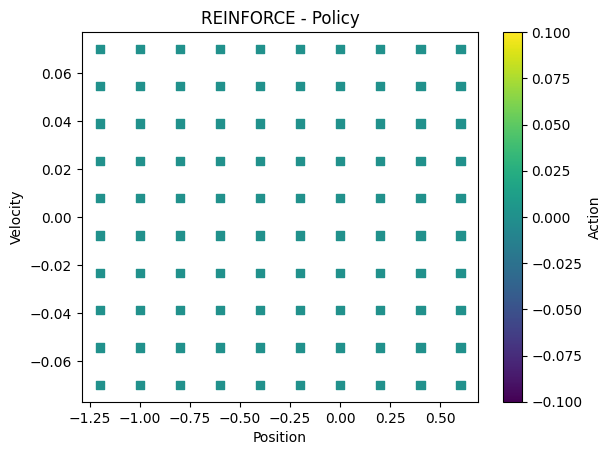

In [11]:
# Genera una griglia di stati
num_points = 10
x = np.linspace(low[0], high[0], num_points)
y = np.linspace(low[1], high[1], num_points)
xx, yy = np.meshgrid(x, y)
grid_states = np.c_[xx.ravel(), yy.ravel()]

# Ottieni le azioni predette per ogni stato nella griglia
predicted_actions = [agent.act(state) for state in grid_states]

# Visualizza la policy
plt.scatter(xx, yy, c=predicted_actions, cmap='viridis', marker='s')
plt.title('REINFORCE - Policy')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.colorbar(label='Action')
plt.show()

In [ ]:
RENDER = True
SHOW_EVERY = 50
if RENDER:
    env = gym.make("MountainCar-v0", render_mode="rgb_array_list")

state_dim = env.observation_space.shape[0] # 2
num_actions = env.action_space.n           # 3

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(state_dim,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(num_actions, activation='softmax')
])

class REINFORCE():
    def __init__(self):
        self.model = model
        self.opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.gamma = 1

    def act(self, state):
        state = np.reshape(env.state, [1, state_dim])                      # crea una matrice bidimensionale
        prob = self.model.predict(state, verbose=0)[0]                     # fa predict con la NN
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32) # POLICY - crea una distribuzione di probabilità categorica con le probabilità ricevute dalla NN
        action = dist.sample()                                             # prende un campione
        return int(action.numpy())

    def a_loss(self, prob, action, reward):
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        log_prob = dist.log_prob(action)
        loss = log_prob*reward
        return loss

    def train(self, states, rewards, actions):
        discnt_rewards = []
        T = len(rewards)
        for t in range(T):
            G_t = 0
            for k in range(t,T):
                G_t += pow(self.gamma,k) * rewards[k]
            discnt_rewards.append(G_t)

        for state, reward, action in zip(states, discnt_rewards, actions):
            with tf.GradientTape() as tape:                                      # Apre un contesto di registrazione del gradiente
                p = self.model(np.array([state]), training=True)                 # Ottiene le probabilità predette dal modello per uno stato
                loss = self.a_loss(p, action, reward)                            # Calcola la loss
            grads = tape.gradient(loss, self.model.trainable_variables)          # Calcola i gradienti della perdita rispetto ai parametri del modello
            self.opt.apply_gradients(zip(grads, self.model.trainable_variables)) # Applica gli aggiornamenti dei parametri del modello utilizzando l'ottimizzatore Adam



agent = REINFORCE()

steps = 1000

for s in range(steps):
    
    env.reset()
    state = env.state

    total_reward = 0
    rewards = []
    states = []
    actions = []

    done = False
    while not done:
        action = agent.act(state)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        rewards.append(reward)
        states.append(state)
        actions.append(action)

        state = next_state
        total_reward += reward

        if done:
            agent.train(states, rewards, actions)
            #print("total step for this episord are {}".format(t))
            print("total reward after {} steps is {}".format(s, total_reward))

    #if (RENDER and s % SHOW_EVERY == 0):
        #imageio.mimsave(f'./gifs/{s}.gif', env.render(), fps=30)

In [ ]:
RENDER = True
SHOW_EVERY = 50
env = gym.make("MountainCar-v0")
if RENDER:
    env = gym.make("MountainCar-v0", render_mode="rgb_array_list")
    
input_shape = env.observation_space.shape[0]
num_actions = env.action_space.n

policy_network = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_actions, activation='softmax')
])

# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Set up lists to store episode rewards and lengths
episode_rewards = []
episode_lengths = []

num_episodes = 1001
discount_factor = 0.99

# Train the agent using the REINFORCE algorithm
for episode in range(num_episodes):
    # Reset the environment and get the initial state
    env.reset()
    state = env.state
    episode_reward = 0
    episode_length = 0

    # Keep track of the states, actions, and rewards for each step in the episode
    states = []
    actions = []
    rewards = []

    # Run the episode
    done = False
    while not done:
        # Get the action probabilities from the policy network
        action_probs = policy_network.predict(np.array([state]), verbose=0)[0]

        # Choose an action based on the action probabilities
        action = np.random.choice(num_actions, p=action_probs)

        # Take the chosen action and observe the next state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store the current state, action, and reward
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        # Update the current state and episode reward
        state = next_state
        episode_reward += reward
        episode_length += 1

        # End the episode if the environment is done
        if done:
            print('Episode {}: {}'.format(episode, episode_reward))

    # Calculate the discounted rewards for each step in the episode
    discounted_rewards = np.zeros_like(rewards)
    running_total = 0
    for i in reversed(range(len(rewards))):
        running_total = running_total * discount_factor + rewards[i]
        discounted_rewards[i] = running_total

    # Normalize the discounted rewards
    discounted_rewards -= np.mean(discounted_rewards)
    discounted_rewards /= np.std(discounted_rewards)

    # Convert the lists of states, actions, and discounted rewards to tensors
    states = tf.convert_to_tensor(states)
    actions = tf.convert_to_tensor(actions)
    discounted_rewards = tf.convert_to_tensor(discounted_rewards)

    # Train the policy network using the REINFORCE algorithm
    with tf.GradientTape() as tape:
        # Get the action probabilities from the policy network
        action_probs = policy_network(states)
        # Calculate the loss
        loss = tf.cast(tf.math.log(tf.gather(action_probs,actions,axis=1,batch_dims=1)),tf.float64)
        
        loss = loss * discounted_rewards
        '''loss = -tf.reduce_sum(loss)'''
        loss = tf.reduce_sum(loss)

    # Calculate the gradients and update the policy network
    grads = tape.gradient(loss, policy_network.trainable_variables)
    optimizer.apply_gradients(zip(grads, policy_network.trainable_variables))

    # Store the episode reward and length
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)
    
    #policy_network.save('keras/')
    #policy_network = tf.keras.models.load_model('keras/')

    if (RENDER and episode % SHOW_EVERY == 0):
        imageio.mimsave(f'./gifs/{episode}.gif', env.render(), fps=30)